**Diseño de Redes Neuronales y Aprendizaje Produndo**

# **Red Neuronal Residual para Clasificación de Imágenes**

**Alumno:** Kevin Martinez Trinidad.    **Matrícula:** A00834493  
**Alumno:** Miranda Isabel Rada Chau.   **Matrícula:** A01285243  
**Alumno:** Juan José H. Beltrán.       **Matrícula:** A00836747

## **Setup**

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import random
random.seed(31)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Algunas características de los datos
filas = 28
columnas = 28
canales = 1 # Escala de grises
clases = 10
label_names = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## **Preparación de Datos**

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
# Normalizar a valores entre 0 y 1
X_train = X_train/255
X_test = X_test/255

In [ ]:
# Convertir los labels a one hot encoding
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Y_train = convert_to_one_hot(Y_train, clases).T
Y_test = convert_to_one_hot(Y_test, clases).T

In [ ]:
print ("Número de ejemplos de entrenamiento:", X_train.shape[0])
print ("Número de entrenamientos de prueba", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)

Número de ejemplos de entrenamiento: 60000
Número de entrenamientos de prueba 10000
X_train shape: (60000, 28, 28)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28)
Y_test shape: (10000, 10)


### **Reducción de Muestras (para Pruebas)**

Solo durante las pruebas inciales de validación, para encontrar los mejores hiperparámetros, se redujo el tamaño de los sets para accelerar el tiempo de entrenamiento de la red. Se conservarion únicamente 2000 datos de entrenamiento y 200 datos de prueba.

In [ ]:
# Tamaños de muestra
muestra_train = 2500
muestra_test = 500

# Generar muestras para entrenamiento
muestra = random.sample(list(range(X_train.shape[0])), k = muestra_train)
X_train = X_train[muestra, :]
Y_train = Y_train[muestra, :]

# Generar muestras para prueba
muestra = random.sample(list(range(X_test.shape[0])), k = muestra_test)
X_test = X_test[muestra, :]
Y_test = Y_test[muestra, :]

In [ ]:
print ("Número de ejemplos de entrenamiento:", X_train.shape[0])
print ("Número de entrenamientos de prueba", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)

Número de ejemplos de entrenamiento: 2500
Número de entrenamientos de prueba 500
X_train shape: (2500, 28, 28)
Y_train shape: (2500, 10)
X_test shape: (500, 28, 28)
Y_test shape: (500, 10)


## **Algunas Funciones y Estructuras**

### **Identity Block**

In [ ]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X})
    print("out = ", out[0][1][1][0])

out =  [0.         0.         0.         0.         0.07676294 0.5829043 ]


### **Convolutional Block**

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)


    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X})
    print("out = ",out[0][1][1][0])

out =  [0.76070505 0.         0.31173927 0.         0.21988699 0.10925141]


## **Implementación de la Arquitectura**

In [ ]:
def ResNet50(input_shape, classes):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(1, 1))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [28, 28, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [28, 28, 256], stage=2, block='b')
    X = identity_block(X, 3, [28, 28, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
# Construir el modelo
model = ResNet50(input_shape = (filas, columnas, canales), classes = clases)
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## **Entrenamiento del Modelo**

In [ ]:
n_epochs = 30
n_batch = 32

In [ ]:
H = model.fit(X_train, Y_train, epochs = n_epochs, batch_size = n_batch, validation_split=0.1)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - accuracy: 0.3850 - loss: 27.0239 - val_accuracy: 0.1960 - val_loss: 2.5021
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.6860 - loss: 3.0913 - val_accuracy: 0.1320 - val_loss: 3.5412
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.7540 - loss: 1.7404 - val_accuracy: 0.2040 - val_loss: 2.4174
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.7981 - loss: 1.7140 - val_accuracy: 0.2040 - val_loss: 2.4117
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.7584 - loss: 1.9657 - val_accuracy: 0.5800 - val_loss: 1.2737
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.7156 - loss: 1.8721 - val_accuracy: 0.6160 - val_loss: 1.3007
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.8207 - loss: 0.8710 - val_accuracy: 0.7080 - val_loss: 0.8695
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.8468 - loss: 0.5782 - val_acc

## **Evaluación del Modelo**

### **Curvas de Aprendizaje**

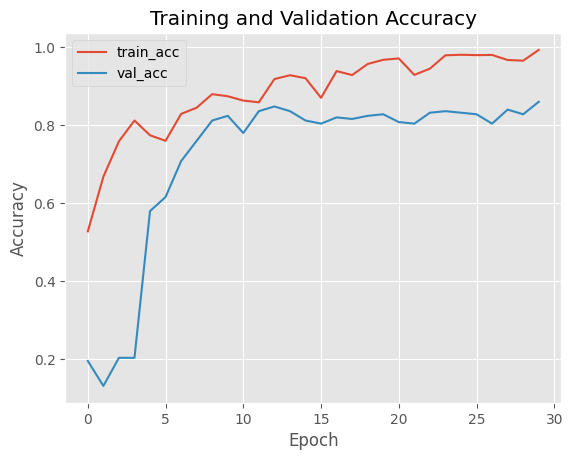

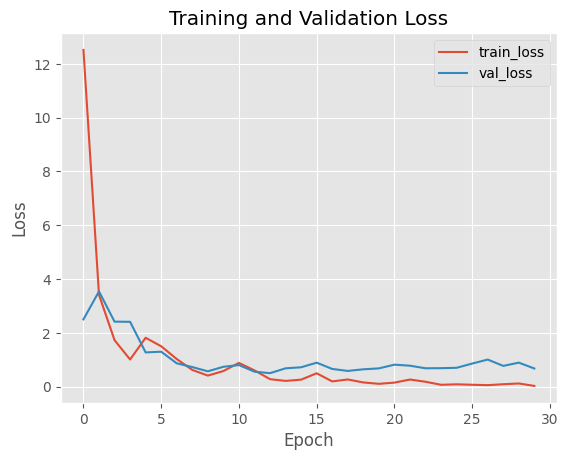

In [ ]:
# Despliega las curvas de aprendizaje
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### **Algunas Métricas**

In [ ]:
# Estadísticas de desempeño de la red
predictions = model.predict(X_test, batch_size=n_batch)
print(classification_report(Y_test.argmax(axis=1),
      predictions.argmax(axis=1), target_names = label_names))

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step
              precision    recall  f1-score   support

     T-shirt       0.79      0.75      0.77        40
     Trouser       0.97      0.92      0.94        37
    Pullover       0.80      0.71      0.75        51
       Dress       0.83      0.87      0.85        46
        Coat       0.69      0.67      0.68        55
      Sandal       0.98      0.96      0.97        51
       Shirt       0.69      0.73      0.71        66
     Sneaker       0.91      1.00      0.95        52
         Bag       0.91      0.98      0.94        50
  Ankle boot       1.00      0.94      0.97        52

    accuracy                           0.85       500
   macro avg       0.86      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



### **Matriz de Confusión**

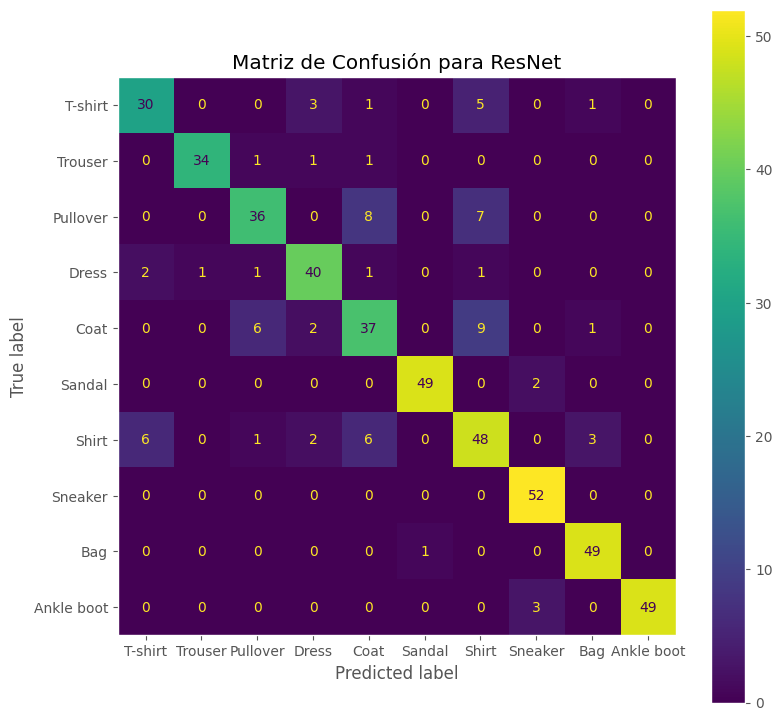

In [ ]:
# Matriz de confusión
cm = confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1))

# Crear la visualización de la matriz de confusión
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_names)

# Graficar la matriz de confusión
cm_display.plot()
cm_display.ax_.set(title='Matriz de Confusión para ResNet')
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(9, 9)

plt.show()

## **Características del Modelo**

In [ ]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 34, 34, 1)      │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 30, 30, 64)     │          1,664 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 30, 30, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_56             │ (None, 30, 30, 64)     │              0 │ bn_conv1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 64)     │              0 │ activation_56[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2a (Conv2D)   │ (None, 28, 28, 28)     │          1,820 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2a             │ (None, 28, 28, 28)     │            112 │ res2a_branch2a[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_57             │ (None, 28, 28, 28)     │              0 │ bn2a_branch2a[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2b (Conv2D)   │ (None, 28, 28, 28)     │          7,084 │ activation_57[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2b             │ (None, 28, 28, 28)     │            112 │ res2a_branch2b[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_58             │ (None, 28, 28, 28)     │              0 │ bn2a_branch2b[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2c (Conv2D)   │ (None, 28, 28, 256)    │          7,424 │ activation_58[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch1 (Conv2D)    │ (None, 28, 28, 256)    │         16,640 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2c             │ (None, 28, 28, 256)    │          1,024 │ res2a_branch2c[0][0]   │
│ (BatchNormalization) 

 Total params: 42,307,048 (161.39 MB)

 Trainable params: 14,094,002 (53.76 MB)

 Non-trainable params: 25,040 (97.81 KB)

 Optimizer params: 28,188,006 (107.53 MB)

Se muestra la imagen de la arquitectura del modelo.

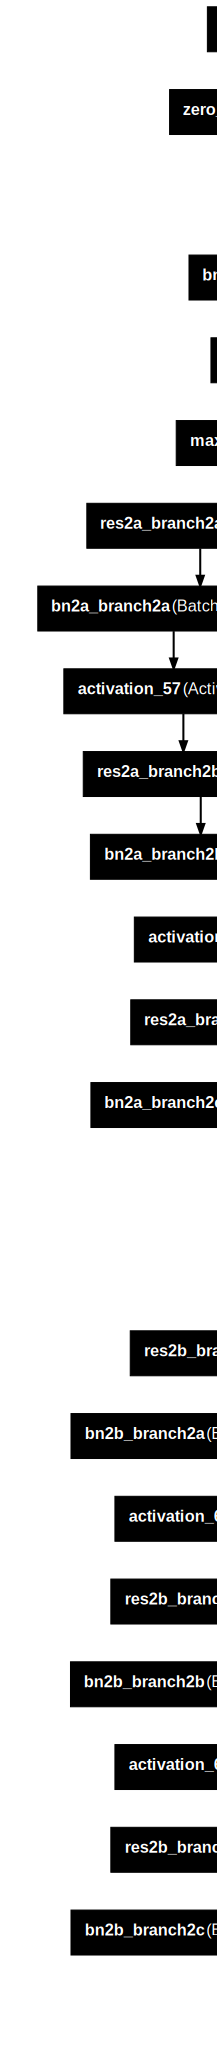

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Se guarda el modelo en un archivo h5 para poder utilizarlo posteriormente sin tener que reentrenar. Se adjunta el archivo en Google Drive.

In [ ]:
model.save('ResNetFashionMNIST.keras')